In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import pandas as pd # for data analytics
import numpy as np # for numerical computation
from matplotlib import pyplot as plt, style # for ploting
import seaborn as sns # for ploting
from sklearn.metrics import fbeta_score, precision_score, recall_score, confusion_matrix # for evaluation
import itertools

style.use('ggplot')
np.random.seed(42)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/dataset/creditcard_f.csv')#.drop('Time', axis=1)
dataset = dataset.sample(frac=0.4)
dataset['Amount'] = np.log(dataset['Amount'] + 1)
dataset['Time'] = np.log(dataset['Time'] + 1)
normal = dataset[dataset['Class'] == 0]

anomaly = dataset[dataset['Class'] == 1]
print(normal.shape)
print(anomaly.shape)

(113732, 31)
(191, 31)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.model_selection import train_test_split

train, normal_test, _, _ = train_test_split(normal, normal, test_size=.2, random_state=42)

normal_valid, normal_test, _, _ = train_test_split(normal_test, normal_test, test_size=.5, random_state=42)
anormal_valid, anormal_test, _, _ = train_test_split(anomaly, anomaly, test_size=.5, random_state=42)

train = train.reset_index(drop=True)
valid = pd.concat([normal_valid, anormal_valid]).sample(frac=1).reset_index(drop=True)
test = pd.concat([normal_test, anormal_test]).sample(frac=1).reset_index(drop=True)

print('Train shape: ', train.shape)
print('Proportion os anomaly in training set: %.2f\n' % train['Class'].mean())
print('Valid shape: ', valid.shape)
print('Proportion os anomaly in validation set: %.2f\n' % valid['Class'].mean())
print('Test shape:, ', test.shape)
print('Proportion os anomaly in test set: %.2f\n' % test['Class'].mean())

Train shape:  (90985, 31)
Proportion os anomaly in training set: 0.00

Valid shape:  (11468, 31)
Proportion os anomaly in validation set: 0.01

Test shape:,  (11470, 31)
Proportion os anomaly in test set: 0.01



Normal transactions: 284315
Fraud transactions: 492


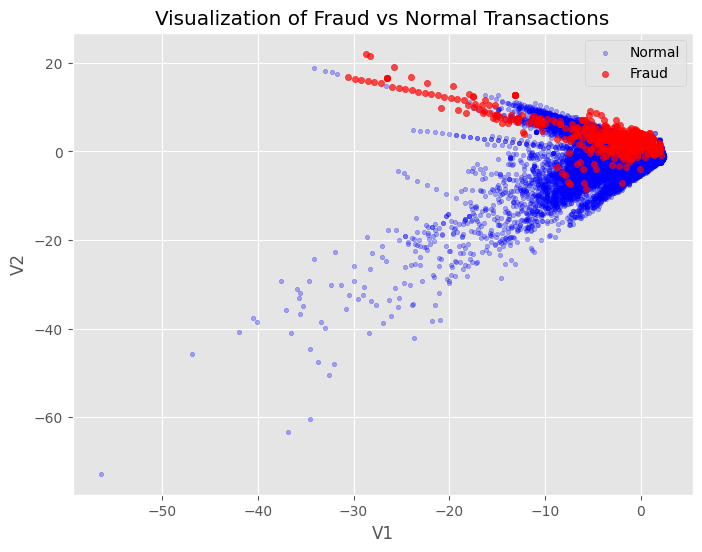

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Load the dataset
dataset = pd.read_csv("/content/drive/MyDrive/dataset/creditcard_f.csv")

# 2️⃣ Separate normal and fraud transactions
normal = dataset[dataset["Class"] == 0]
fraud = dataset[dataset["Class"] == 1]

print(f"Normal transactions: {len(normal)}")
print(f"Fraud transactions: {len(fraud)}")

# 3️⃣ Choose 2 features to visualize (PCA components work well)
# You can change these (like 'V1' & 'V2', or 'V2' & 'V4')
x_feature = 'V1'
y_feature = 'V2'

# 4️⃣ Plot the data
plt.figure(figsize=(8,6))

plt.scatter(normal[x_feature], normal[y_feature],
            c='blue', s=10, alpha=0.3, label='Normal')

plt.scatter(fraud[x_feature], fraud[y_feature],
            c='red', s=20, alpha=0.7, label='Fraud')

plt.title("Visualization of Fraud vs Normal Transactions")
plt.xlabel(x_feature)
plt.ylabel(y_feature)
plt.legend()
plt.show()


In [ ]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, n_init=4, random_state=42)
gmm.fit(train.drop('Class', axis=1).values)
print(gmm.score(valid[valid['Class'] == 0].drop('Class', axis=1).values))
print(gmm.score(valid[valid['Class'] == 1].drop('Class', axis=1).values))

13.175063292591593
-385.97277076178494


Skipping visualization for covariance shape: (30, 30)
Skipping visualization for covariance shape: (30, 30)
Skipping visualization for covariance shape: (30, 30)


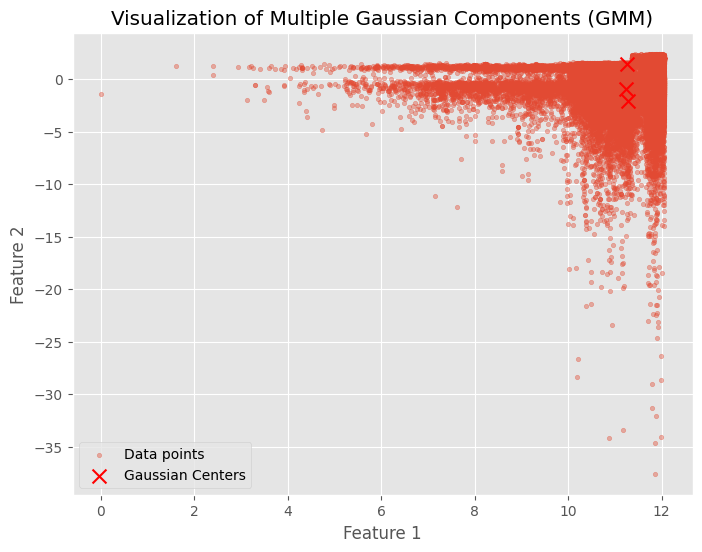

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np

# Function to draw Gaussian ellipses
def draw_ellipse(position, covariance, ax, **kwargs):
    """Draw an ellipse to represent a Gaussian component."""
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle, width, height = 0, 2 * np.sqrt(covariance), 2 * np.sqrt(covariance)

    for nsig in range(1, 4):  # draw 1σ, 2σ, 3σ ellipses
        ax.add_patch(Ellipse(position, nsig*width, nsig*height, angle, **kwargs))

# Plot the data and GMM components
plt.figure(figsize=(8, 6))
ax = plt.gca()

# Data points
# Use the training data for plotting
X_train = train.drop('Class', axis=1).values
plt.scatter(X_train[:, 0], X_train[:, 1], s=10, alpha=0.4, label='Data points')

# Gaussian ellipses and centers
for pos, cov in zip(gmm.means_, gmm.covariances_):
    # Need to handle cases where covariance is not 2x2 for visualization
    if cov.shape == (2, 2):
        draw_ellipse(pos, cov, ax, alpha=0.25, color='red')
    elif cov.ndim == 1:
         # Assuming spherical covariance for 1D case, draw a circle
         circle = plt.Circle(pos[:2], np.sqrt(cov[0]), color='red', alpha=0.25)
         ax.add_patch(circle)
    else:
        # Handle other dimensions or shapes if necessary, or skip
        print(f"Skipping visualization for covariance shape: {cov.shape}")


plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], c='red', s=100, marker='x', label='Gaussian Centers')

plt.title("Visualization of Multiple Gaussian Components (GMM)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import recall_score, precision_score, fbeta_score

tresholds = np.linspace(-400, 0, 100)
y_scores = gmm.score_samples(valid.drop('Class', axis=1).values)
scores = []
for treshold in tresholds:
    y_hat = (y_scores < treshold).astype(int)
    scores.append([recall_score(y_pred=y_hat, y_true=valid['Class'].values),
                 precision_score(y_pred=y_hat, y_true=valid['Class'].values),
                 fbeta_score(y_pred=y_hat, y_true=valid['Class'].values, beta=2)])

scores = np.array(scores)
print(scores[:, 2].max(), scores[:, 2].argmax())

0.7364341085271318 78


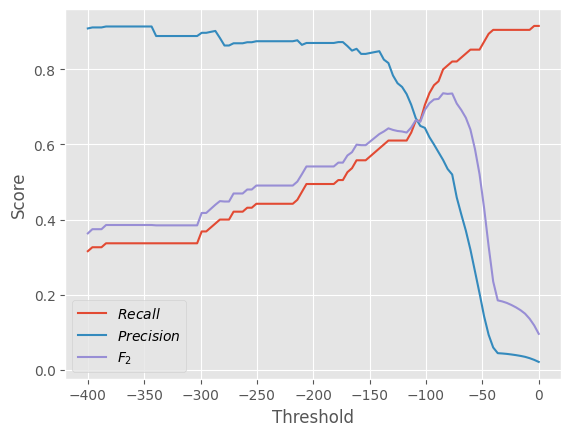

In [ ]:
plt.plot(tresholds, scores[:, 0], label='$Recall$')
plt.plot(tresholds, scores[:, 1], label='$Precision$')
plt.plot(tresholds, scores[:, 2], label='$F_2$')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

Final threshold: -84.848485
Test Recall Score: 0.781
Test Precision Score: 0.625
Test F2 Score: 0.744


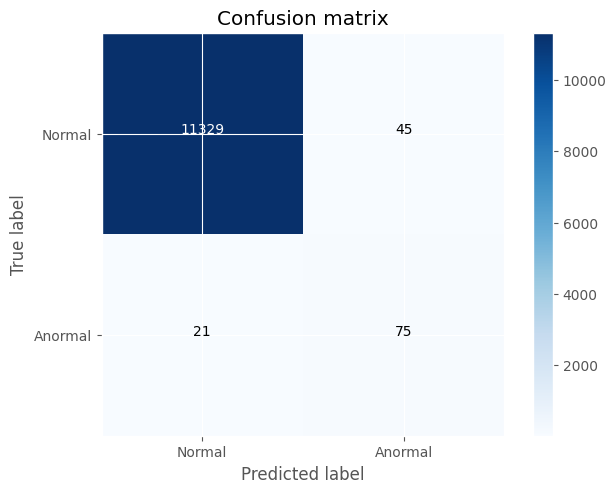

In [ ]:
final_tresh = tresholds[scores[:, 2].argmax()]
y_hat_test = (gmm.score_samples(test.drop('Class', axis=1).values) < final_tresh).astype(int)

print('Final threshold: %f' % final_tresh)
print('Test Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test F2 Score: %.3f' % fbeta_score(y_pred=y_hat_test, y_true=test['Class'].values, beta=2))

cnf_matrix = confusion_matrix(test['Class'].values, y_hat_test)
plot_confusion_matrix(cnf_matrix, classes=['Normal','Anormal'], title='Confusion matrix')

The confusion matrix for the test set is displayed above. Let's break down what the numbers mean:

- **True Negatives (Top-Left)**: This number represents the count of normal transactions that were correctly identified as normal by the model.
- **False Positives (Top-Right)**: This number represents the count of normal transactions that were incorrectly identified as abnormal by the model (Type I error).
- **False Negatives (Bottom-Left)**: This number represents the count of abnormal transactions that were incorrectly identified as normal by the model (Type II error).
- **True Positives (Bottom-Right)**: This number represents the count of abnormal transactions that were correctly identified as abnormal by the model.

Analyzing these values along with the precision, recall, and F2 scores gives us a comprehensive understanding of how well the Gaussian Mixture Model is performing in detecting anomalies on the test set.